## Data Exploration and Preprocessing

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load the features dataset
features_df = pd.read_csv('encoded_df_blanks_as_na.csv')

# Load the labels dataset
labels_df = pd.read_csv('d20240103_texts_with_dates.csv')


In [2]:
# Features dataset
print(features_df.shape)
features_df.head()

(30324, 16384)


,text_id,nam_id_1057.0,nam_id_19683.0,nam_id_356.0,nam_id_904.0,nam_id_2227.0,nam_id_726.0,nam_id_761.0,nam_id_731.0,nam_id_1246.0,...,nam_id_26358.0,nam_id_26392.0,geo_id_7893,geo_id_7670,geo_id_7007,nam_id_27140.0,nam_id_43504.0,nam_id_22369.0,nam_id_26361.0,geo_id_2078
0,1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,NaN,NaN,1.0,1.0,NaN,NaN,1.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
# Labels dataset
print(labels_df.shape)
labels_df.head()

(29250, 12)


,tex_id,geotex_id,written,found,geo_id,language_text,material_text,y1,y2,remark,Unnamed: 10,Unnamed: 11
0,12042,8388,1,1,1008,Greek,papyrus,117.0,118.0,NaN,NaN,- y1 = earliest possible year of writing
1,12054,8391,1,1,1008,Greek,papyrus,119.0,119.0,NaN,NaN,- y2 = latest possible year of writing
2,12063,8393,1,1,1008,Greek,papyrus,96.0,98.0,NaN,NaN,"[if y1 = y2, then we are certain of the date]"
3,12064,8394,1,1,1008,Greek,papyrus,131.0,131.0,NaN,NaN,NaN
4,17239,9507,0,1,1008,Greek,papyrus,108.0,108.0,NaN,NaN,NaN


In [4]:
# Rename tex_id to text_id in labels_df
labels_df.rename(columns={'tex_id': 'text_id'}, inplace=True)

# Merge the two datasets on 'text_id'
merged_df = pd.merge(features_df, labels_df[['text_id', 'y1', 'y2']], on='text_id', how='inner')

# Ensure 'text_id' is the key for merging
# merged_df = pd.merge(features_df, labels_df[['tex_id', 'y1', 'y2']], left_on='text_id', right_on='tex_id')
# merged_df.drop(columns=['tex_id'], inplace=True)


In [5]:
# Check for missing values in the merged dataset
missing_values = merged_df.isnull().sum()
print(missing_values[missing_values > 0])


nam_id_1057.0     13659
nam_id_19683.0    13673
nam_id_356.0      11958
nam_id_904.0      13333
nam_id_2227.0     13510
                  ...  
nam_id_27140.0    13680
nam_id_43504.0    13680
nam_id_22369.0    13680
nam_id_26361.0    13680
geo_id_2078       13680
Length: 16383, dtype: int64


In [6]:
# Fill NaNs in feature columns with zeros
feature_columns = [col for col in merged_df.columns if col.startswith('nam_id_') or col.startswith('geo_id_')]
merged_df[feature_columns] = merged_df[feature_columns].fillna(0)


In [7]:
# Create a new target variable 'year' by averaging y1 and y2 if they differ
merged_df['year'] = merged_df.apply(
    lambda row: (row['y1'] + row['y2']) / 2 if row['y1'] != row['y2'] else row['y1'], 
    axis=1
)

# # Create a new target variable 'year' by averaging y1 and y2 if they are not equal
# merged_df['year'] = merged_df.apply(lambda row: (row['y1'] + row['y2']) / 2 if row['y1'] != row['y2'] else row['y1'], axis=1)

# Drop 'y1' and 'y2' as we have the 'year' now
merged_df.drop(columns=['y1', 'y2'], inplace=True)

# Ensure the data is sorted by year for time-series tasks
#merged_df = merged_df.sort_values('year').reset_index(drop=True)

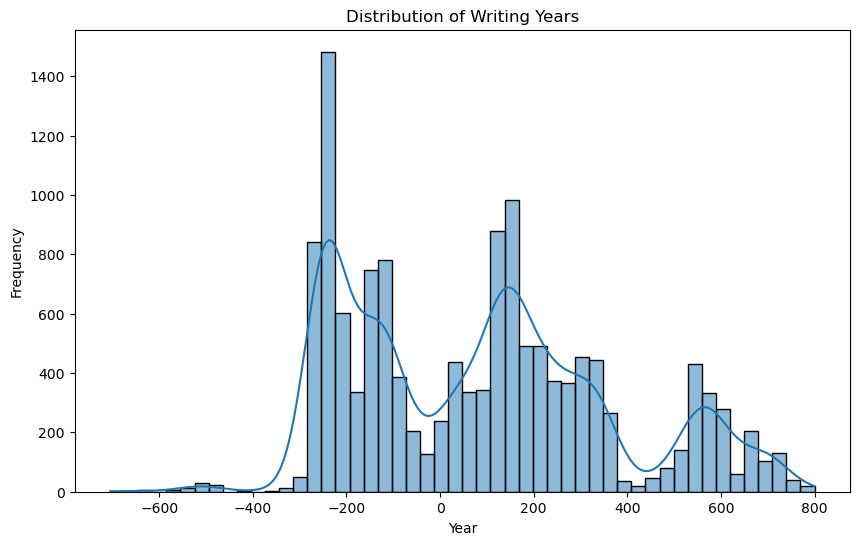

In [8]:
plt.figure(figsize=(10, 6))
sns.histplot(merged_df['year'], bins=50, kde=True)
plt.title('Distribution of Writing Years')
plt.xlabel('Year')
plt.ylabel('Frequency')
plt.show()


## Split Data

In [16]:
# Preprocessing for General Models
from sklearn.model_selection import train_test_split

# Define features and target for general models
feature_columns = [col for col in merged_df.columns if col.startswith('nam_id_') or col.startswith('geo_id_')]
X_general = merged_df[feature_columns]
y_general = merged_df['year']

# Train-test split for general models
X_train_gen, X_test_gen, y_train_gen, y_test_gen = train_test_split(X_general, y_general, test_size=0.2, random_state=42)

## Variance Threshold

In [17]:
from sklearn.feature_selection import VarianceThreshold

# Apply variance threshold on the TRAINING set only
selector = VarianceThreshold(threshold=0.01)  # Adjust threshold as needed

# NOTE: No scaling has happened yet – we use raw `X_train_gen` and `X_test_gen`
X_train_vt = selector.fit_transform(X_train_gen)

# Get the selected feature names
selected_features = X_train_gen.columns[selector.get_support(indices=True)]

# Apply the same feature mask to the test set
X_test_vt = X_test_gen.loc[:, selected_features]

## Correlation-Based Feature Selection

In [18]:
# Convert the filtered training set to a DataFrame for correlation calculation
X_train_vt_df = pd.DataFrame(X_train_vt, columns=selected_features, index=X_train_gen.index)

# Compute correlation with the target
correlations = X_train_vt_df.corrwith(y_train_gen).abs().sort_values(ascending=False)

# Select top N features
top_n = 100
top_features = correlations.index[:top_n]

# Subset the training and test sets with these top features
X_train_filtered = X_train_vt_df[top_features]
X_test_filtered = X_test_vt[top_features]

## Scaling

In [19]:
from sklearn.preprocessing import StandardScaler

# Scaling AFTER feature selection
scaler = StandardScaler()
scaler.fit(X_train_filtered)  # Fit only on the filtered training set
X_train_scaled = scaler.transform(X_train_filtered)
X_test_scaled = scaler.transform(X_test_filtered)

## Model Development

#### 1 - Linear Regression

In [20]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error

lr_model = LinearRegression()
lr_model.fit(X_train_scaled, y_train_gen)
y_pred_lr = lr_model.predict(X_test_scaled)
mae_lr = mean_absolute_error(y_test_gen, y_pred_lr)
rmse_lr = np.sqrt(mean_squared_error(y_test_gen, y_pred_lr))
print(f"Linear Regression MAE: {mae_lr:.2f}")
print(f"Linear Regression RMSE: {rmse_lr:.2f}")

Linear Regression MAE: 128.06
Linear Regression RMSE: 175.94


#### 1 - Random Forest Regressor

In [21]:
from sklearn.ensemble import RandomForestRegressor

rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train_scaled, y_train_gen)
y_pred_rf = rf_model.predict(X_test_scaled)
mae_rf = mean_absolute_error(y_test_gen, y_pred_rf)
rmse_rf = np.sqrt(mean_squared_error(y_test_gen, y_pred_rf))
print(f"Random Forest MAE: {mae_rf:.2f}")
print(f"Random Forest RMSE: {rmse_rf:.2f}")

Random Forest MAE: 78.51
Random Forest RMSE: 131.24


#### 1 - Gradient Boosting Regressor

In [22]:
from sklearn.ensemble import GradientBoostingRegressor

gb_model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
gb_model.fit(X_train_scaled, y_train_gen)
y_pred_gb = gb_model.predict(X_test_scaled)
mae_gb = mean_absolute_error(y_test_gen, y_pred_gb)
rmse_gb = np.sqrt(mean_squared_error(y_test_gen, y_pred_gb))
print(f"Gradient Boosting MAE: {mae_gb:.2f}")
print(f"Gradient Boosting RMSE: {rmse_gb:.2f}")

Gradient Boosting MAE: 119.24
Gradient Boosting RMSE: 163.53


#### 1 - Evaluation Summary for General Models

In [23]:
results = pd.DataFrame({
    'Model': ['Linear Regression', 'Random Forest', 'Gradient Boosting'],
    'MAE': [mae_lr, mae_rf, mae_gb],
    'RMSE': [rmse_lr, rmse_rf, rmse_gb]
})
print(results)

               Model         MAE        RMSE
0  Linear Regression  128.063689  175.941723
1      Random Forest   78.510109  131.243799
2  Gradient Boosting  119.242423  163.534007


#### 2 - Cross Validation

In [25]:
from sklearn.model_selection import cross_val_score

# Function to perform cross-validation
def evaluate_model(model):
    scores = cross_val_score(model, X_train_scaled, y_train_gen, scoring='neg_mean_absolute_error', cv=5)
    mae_scores = -scores
    print(f"{model.__class__.__name__} MAE CV Scores: {mae_scores}")
    print(f"Average MAE: {mae_scores.mean():.2f}")

evaluate_model(LinearRegression())

evaluate_model(RandomForestRegressor(n_estimators=100, random_state=42))

evaluate_model(GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, random_state=42))

LinearRegression MAE CV Scores: [132.26358732 135.98207713 137.16039033 136.31486235 140.0308294 ]
Average MAE: 136.35
RandomForestRegressor MAE CV Scores: [80.71086068 85.95259924 84.96899184 82.71091274 83.89064085]
Average MAE: 83.65
GradientBoostingRegressor MAE CV Scores: [122.11775733 126.52234679 128.23452187 126.2136662  130.16405729]
Average MAE: 126.65


### Handling Temporal Data

#### Time Series Features and Scaling

In [26]:
from sklearn.model_selection import TimeSeriesSplit

# Add lagged features for time-series models
for lag in range(1, 4): # Create lagged features up to 3 periods
    merged_df[f'lag_{lag}'] = merged_df['year'].shift(lag)

# Drop NaN values caused by lagging
merged_df_ts = merged_df.dropna()

# Define features and target for time-series models
X_ts = merged_df_ts[[col for col in merged_df_ts.columns if col.startswith('lag_') or col.startswith('nam_id_') or col.startswith('geo_id_')]]
y_ts = merged_df_ts['year']

# Initialize TimeSeriesSplit
from sklearn.model_selection import TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)

time_series_results = [] # To store results

#### Time Series using Gradient Boosting Regressor

In [27]:
for train_index, test_index in tscv.split(X_ts, y_ts):
    
    # Split the data
    X_train_ts, X_test_ts = X_ts.iloc[train_index], X_ts.iloc[test_index]
    y_train_ts, y_test_ts = y_ts.iloc[train_index], y_ts.iloc[test_index]
    
    # Apply scaling
    scaler_ts = StandardScaler()
    X_train_ts_scaled = scaler_ts.fit_transform(X_train_ts)
    X_test_ts_scaled = scaler_ts.transform(X_test_ts)
    
    # Train the model
    gbr_ts_model = GradientBoostingRegressor(n_estimators=200, learning_rate=0.05, random_state=42)
    gbr_ts_model.fit(X_train_ts_scaled, y_train_ts)
    
    # Make predictions and evaluate
    y_pred_ts = gbr_ts_model.predict(X_test_ts_scaled)
    mae_ts = mean_absolute_error(y_test_ts, y_pred_ts)
    time_series_results.append(mae_ts)
    print(f"Time Series Split MAE: {mae_ts:.2f}")

# Average Time-Series MAE
average_mae_ts = np.mean(time_series_results)
print(f"Average Time Series Split MAE: {average_mae_ts:.2f}")

Time Series Split MAE: 62.88
Time Series Split MAE: 55.23
Time Series Split MAE: 88.30
Time Series Split MAE: 44.87
Time Series Split MAE: 69.30
Average Time Series Split MAE: 64.12


### Feature Importance

In [28]:
# Feature importance from Random Forest
importances_rf = rf_model.feature_importances_
indices_rf = np.argsort(importances_rf)[::-1]

top_n = 10
top_features_rf = [top_features[i] for i in indices_rf[:top_n]]

print("Top 10 Important Features from Random Forest:")
for i, feature in enumerate(top_features_rf):
    print(f"{i+1}. {feature} ({importances_rf[indices_rf[i]]:.4f})")


Top 10 Important Features from Random Forest:
1. nam_id_2429.0 (0.1562)
2. nam_id_3464.0 (0.1363)
3. nam_id_6465.0 (0.1089)
4. geo_id_237 (0.0661)
5. nam_id_11846.0 (0.0339)
6. nam_id_1349.0 (0.0316)
7. nam_id_4077.0 (0.0296)
8. nam_id_8930.0 (0.0276)
9. nam_id_5124.0 (0.0224)
10. nam_id_3794.0 (0.0215)


### Visualizations

#### Predicted vs Actual Values

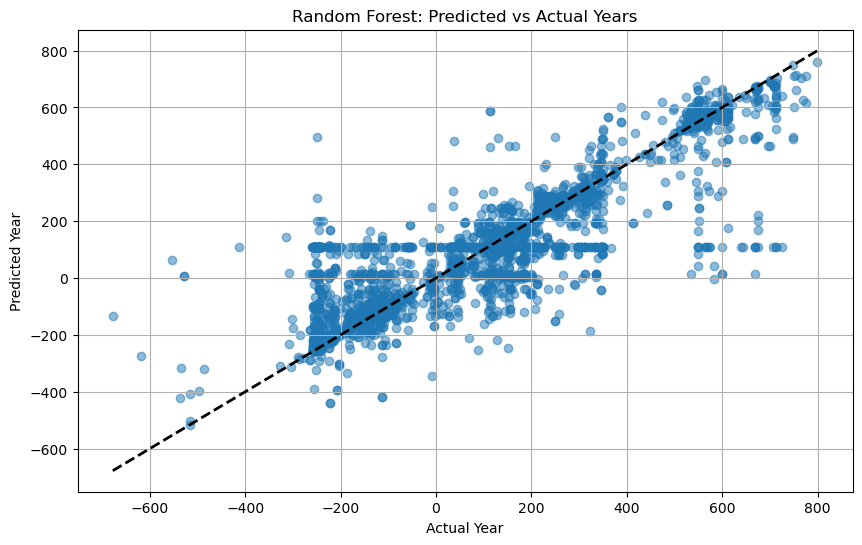

In [30]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test_gen, y_pred_rf, alpha=0.5)
plt.title('Random Forest: Predicted vs Actual Years')
plt.xlabel('Actual Year')
plt.ylabel('Predicted Year')

plt.plot([y_test_gen.min(), y_test_gen.max()], [y_test_gen.min(), y_test_gen.max()], 'k--', lw=2)
plt.grid()
plt.show()

#### Residual Analysis

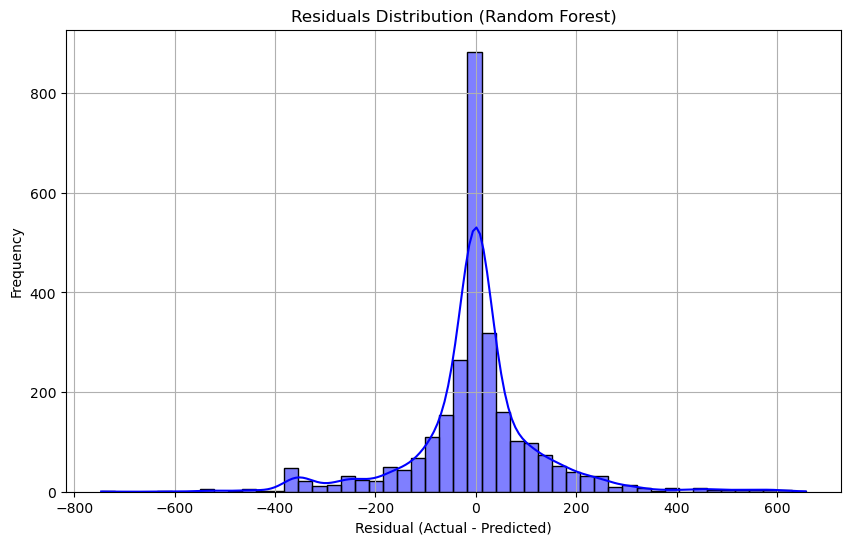

In [31]:
residuals = y_test_gen - y_pred_rf

plt.figure(figsize=(10, 6))
sns.histplot(residuals, bins=50, kde=True, color='blue')
plt.title('Residuals Distribution (Random Forest)')
plt.xlabel('Residual (Actual - Predicted)')
plt.ylabel('Frequency')
plt.grid()
plt.show()

### Hyperparameter Tuning

#### Random Search for Random Forest

In [32]:
from sklearn.model_selection import RandomizedSearchCV

param_dist_rf = {
    'n_estimators': [100, 200, 300, 500],
    'max_depth': [None, 10, 20, 30, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None]
}

random_search_rf = RandomizedSearchCV(
    estimator=RandomForestRegressor(random_state=42),
    param_distributions=param_dist_rf,
    n_iter=50,
    cv=5,
    scoring='neg_mean_absolute_error',
    random_state=42,
    verbose=2,
    n_jobs=-1
)

# Fit the random search to the data
random_search_rf.fit(X_train_scaled, y_train_gen)

# Best parameters
print(f"Best Parameters: {random_search_rf.best_params_}")
print(f"Best MAE: {-random_search_rf.best_score_:.2f}")

# Train a model with the best parameters
best_rf = random_search_rf.best_estimator_
y_pred_best_rf = best_rf.predict(X_test_scaled)

# Evaluate the optimized Random Forest model
mae_best_rf = mean_absolute_error(y_test_gen, y_pred_best_rf)
rmse_best_rf = np.sqrt(mean_squared_error(y_test_gen, y_pred_best_rf))

print(f"Optimized Random Forest MAE: {mae_best_rf:.2f}")
print(f"Optimized Random Forest RMSE: {rmse_best_rf:.2f}")

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best Parameters: {'n_estimators': 300, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': None}
Best MAE: 82.12
Optimized Random Forest MAE: 76.09
Optimized Random Forest RMSE: 128.30


### Advanced Feature Engineering

#### Principal Component Analysis (PCA)

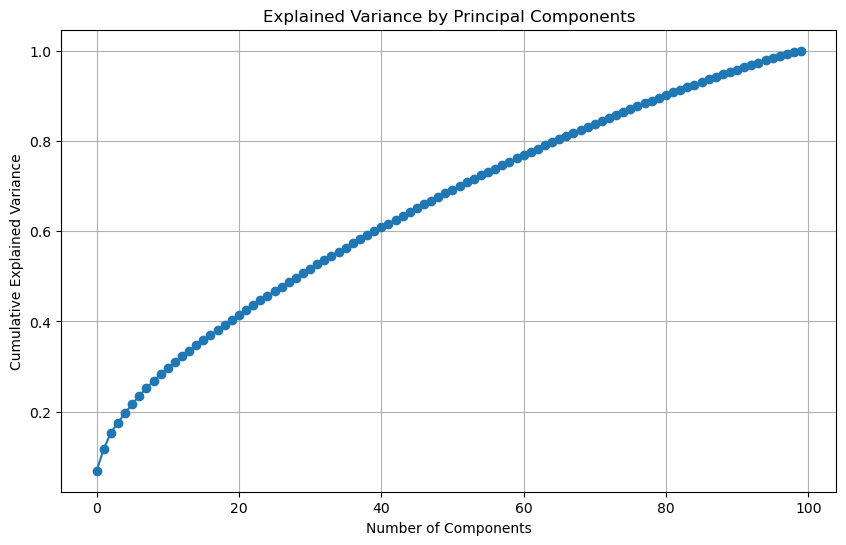

In [33]:
from sklearn.decomposition import PCA

# Apply PCA to reduce dimensionality
pca = PCA(n_components=100) # keep top 100 components
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

# Explained variance ratio
explained_variance = np.cumsum(pca.explained_variance_ratio_)
plt.figure(figsize=(10, 6))
plt.plot(explained_variance, marker='o')
plt.title('Explained Variance by Principal Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid()
plt.show()

#### t-SNE for Visualization

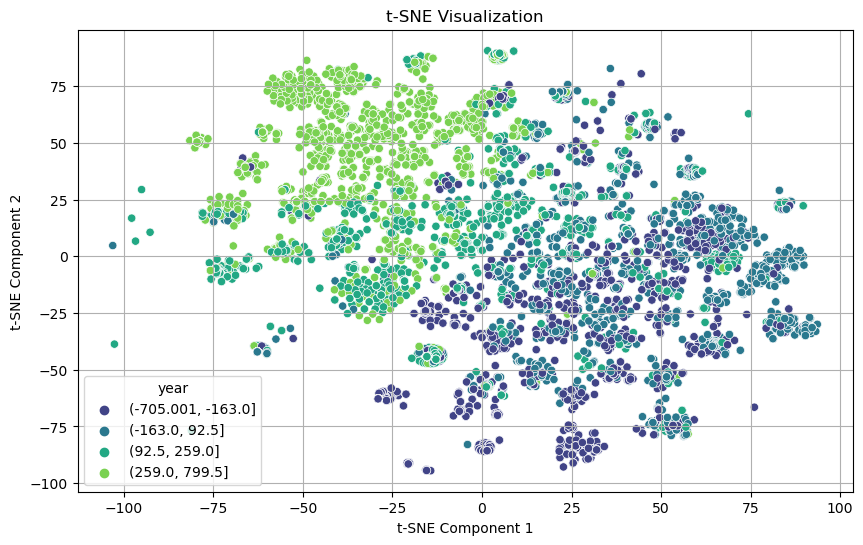

In [34]:
from sklearn.manifold import TSNE

# Apply t-SNE for visualization
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X_train_scaled)

# Scatter plot of the t-SNE results
plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], 
                hue=pd.qcut(y_train_gen, q=4), 
                palette='viridis')
plt.title('t-SNE Visualization')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.grid()
plt.show()

### Time Series - Autoregressive Modeling

#### Auto ARIMA

In [50]:
from pmdarima import auto_arima

# Use the scaled and processed time-series target (`y_ts`)
auto_arima_model = auto_arima(
    y_ts,  # Target column for time series
    seasonal=False,  # Assuming no seasonality
    stepwise=True,
    trace=True
)

# Summarize the Auto ARIMA model
print(auto_arima_model.summary())

# Forecast future years (adjust `n_periods` as needed)
forecast = auto_arima_model.predict(n_periods=10)
print(f"Forecasted Years: {forecast}")

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=160741.214, Time=8.31 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=162263.775, Time=0.22 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=161832.186, Time=0.55 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=161538.301, Time=1.80 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=162261.776, Time=0.13 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=160763.898, Time=6.04 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=160764.279, Time=4.52 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=160657.412, Time=14.40 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=160684.502, Time=6.97 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=160688.327, Time=8.67 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=160737.155, Time=10.96 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=160663.548, Time=14.92 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=160676.698, Time=9.04 sec
 ARIMA(4,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=20.42 sec
 ARIMA(3

C:\Users\chris\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\chris\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


#### SARIMAX

In [51]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Use SARIMAX with lagged features as exogenous variables
sarimax_model = SARIMAX(
    y_ts,  # Target column for time series
    exog=X_ts.iloc[:, :10],  # Use top 10 lagged features or other relevant features
    order=(5, 1, 0)  # ARIMA parameters (adjust as needed)
).fit()

# Summarize the SARIMAX model
print(sarimax_model.summary())

# Forecast future years
forecast = sarimax_model.forecast(steps=10, exog=X_ts.iloc[-10:, :10])
print(f"Forecasted Years: {forecast}")

C:\Users\chris\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\chris\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                   year   No. Observations:                13677
Model:               SARIMAX(5, 1, 0)   Log Likelihood              -80460.515
Date:                Sat, 14 Dec 2024   AIC                         160953.029
Time:                        23:02:43   BIC                         161073.403
Sample:                             0   HQIC                        160993.149
                              - 13677                                         
Covariance Type:                  opg                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
nam_id_1057.0    -10.5021     17.013     -0.617      0.537     -43.847      22.843
nam_id_19683.0    -6.9708     70.139     -0.099      0.921    -144.440     130.499
nam_id_356.0     -12.3164      1.962

C:\Users\chris\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\chris\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


#### Seasonal

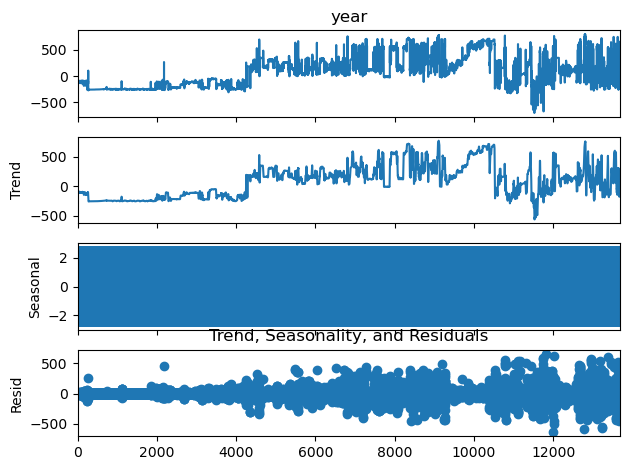

In [52]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Decompose the time series (using the original `year` column for this visualization)
result = seasonal_decompose(merged_df['year'], model='additive', period=12)

# Plot the decomposition
result.plot()
plt.title("Trend, Seasonality, and Residuals")
plt.show()

### Model Comparison After Enhancements

#### Combine all improvements (e.g., PCA, tuned Random Forest) and evaluate:

In [54]:
# Train the optimized model on PCA-reduced data
best_rf_pca = random_search_rf.best_estimator_
best_rf_pca.fit(X_train_pca, y_train_gen)

# Evaluate
y_pred_pca_rf = best_rf_pca.predict(X_test_pca)
mae_pca_rf = mean_absolute_error(y_test_gen, y_pred_pca_rf)
rmse_pca_rf = np.sqrt(mean_squared_error(y_test_gen, y_pred_pca_rf))

print(f"Optimized Random Forest with PCA MAE: {mae_pca_rf:.2f}")
print(f"Optimized Random Forest with PCA RMSE: {rmse_pca_rf:.2f}")

Optimized Random Forest with PCA MAE: 79.80
Optimized Random Forest with PCA RMSE: 130.78


## Neural Net Workflow

1) Scaled y variable to NN

2) PCA (n=100)

3) Created validation set

4) Set up model and layers (messed with regularizations, batch normalization, and drop out)

5) Compile, fitting/training

6) make predictions while unscaling y variable (to see performance in years, not scaled values)

In [56]:
from keras.models import Sequential
from keras.layers import Dense, BatchNormalization, Dropout
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import StandardScaler

# Rescale `y_train_gen` and `y_test_gen` for Neural Network
scaler_y = StandardScaler()
y_train_gen_scaled = scaler_y.fit_transform(y_train_gen.values.reshape(-1, 1))
y_test_gen_scaled = scaler_y.transform(y_test_gen.values.reshape(-1, 1))

# PCA with `X_train_scaled` and `X_test_scaled`
pca = PCA(n_components=100)  # Reduce to 100 dimensions
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

# Train-validation split for the Neural Network
X_train_pca, X_val_pca, y_train_pca, y_val_pca = train_test_split(
    X_train_pca, y_train_gen_scaled, test_size=0.2, random_state=42
)

# Neural Network architecture
model = Sequential()
model.add(Dense(128, activation='relu', input_dim=X_train_pca.shape[1]))
# Uncomment for optional Batch Normalization or Dropout
# model.add(BatchNormalization())
# model.add(Dropout(0.2))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='linear'))  # Linear activation for regression

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_absolute_error', metrics=['mae'])

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
history = model.fit(
    X_train_pca, y_train_pca,
    validation_data=(X_val_pca, y_val_pca),
    epochs=100,
    batch_size=32,
    callbacks=[early_stopping],
    verbose=1
)

# Evaluate the model on the test set
test_loss, test_mae = model.evaluate(X_test_pca, y_test_gen_scaled, verbose=1)
print(f"Test Loss (MSE): {test_loss:.4f}")
print(f"Test MAE: {test_mae:.4f}")


Epoch 1/100


274/274 [==============================] - 2s 2ms/step - loss: 0.4602 - mae: 0.4602 - val_loss: 0.3733 - val_mae: 0.3733
Epoch 2/100
274/274 [==============================] - 0s 1ms/step - loss: 0.3557 - mae: 0.3557 - val_loss: 0.3468 - val_mae: 0.3468
Epoch 3/100
274/274 [==============================] - 0s 1ms/step - loss: 0.3289 - mae: 0.3289 - val_loss: 0.3308 - val_mae: 0.3308
Epoch 4/100
274/274 [==============================] - 0s 1ms/step - loss: 0.3135 - mae: 0.3135 - val_loss: 0.3257 - val_mae: 0.3257
Epoch 5/100
274/274 [==============================] - 0s 1ms/step - loss: 0.3058 - mae: 0.3058 - val_loss: 0.3115 - val_mae: 0.3115
Epoch 6/100
274/274 [==============================] - 0s 1ms/step - loss: 0.2973 - mae: 0.2973 - val_loss: 0.3107 - val_mae: 0.3107
Epoch 7/100
274/274 [==============================] - 0s 1ms/step - loss: 0.2926 - mae: 0.2926 - val_loss: 0.3089 - val_mae: 0.3089
Epoch 8/100
274/274 [==============================] - 0s 2ms/step

### Prediction and Inverse Transformation

In [58]:
# Predict and inverse transform
y_pred = scaler_y.inverse_transform(model.predict(X_test_pca))

# Transform the test set targets back to the original scale
y_test_original = scaler_y.inverse_transform(y_test_gen_scaled)


mae = mean_absolute_error(y_test_original, y_pred)
mse = mean_squared_error(y_test_original, y_pred)
print(f"Mean Absolute Error: {mae:.2f}")
print(f"Mean Squared Error: {mse:.2f}")

86/86 [==============================] - 0s 841us/step
Mean Absolute Error: 77.64
Mean Squared Error: 17867.14


### Plotting performance

#### Training vs Validation Loss

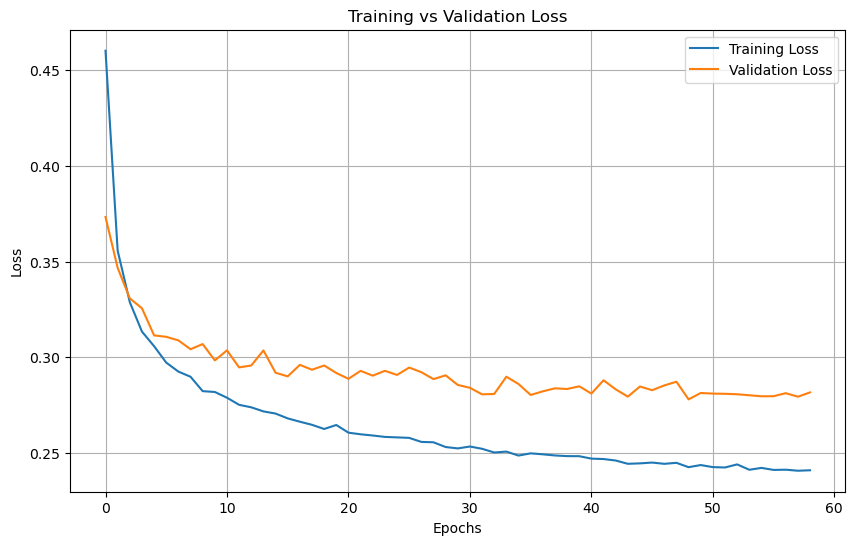

In [59]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.grid()
plt.show()

#### Actual vs Predicted Values

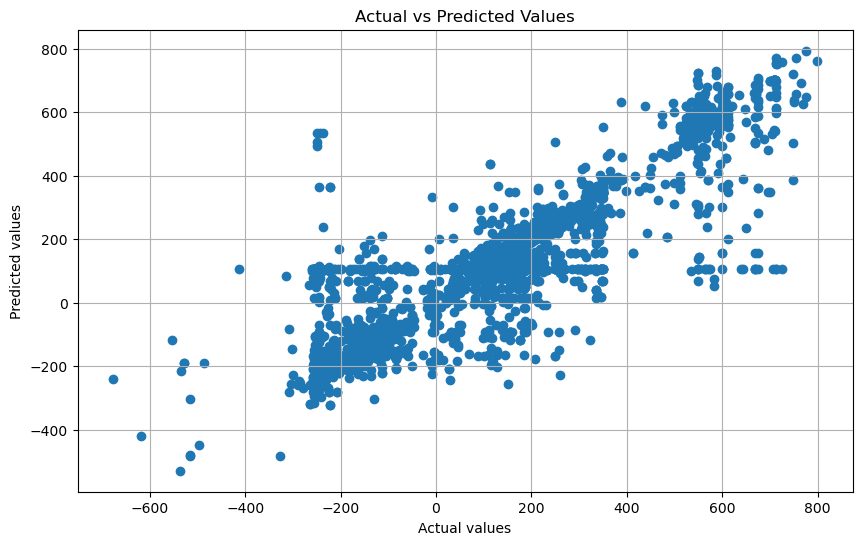

In [60]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test_original, y_pred)
plt.xlabel("Actual values")
plt.ylabel("Predicted values")
plt.title("Actual vs Predicted Values")
plt.grid()
plt.show()

#### Residual Analysis

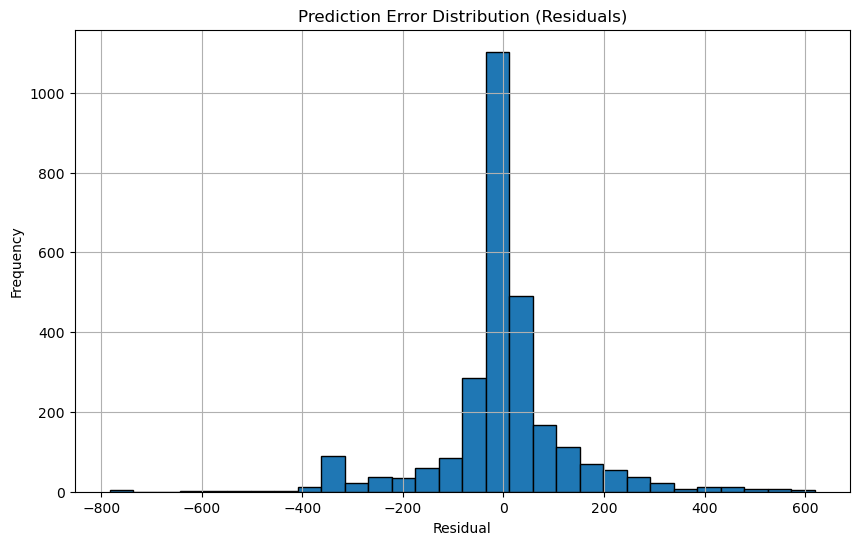

In [61]:
residuals = y_test_original - y_pred
plt.figure(figsize=(10, 6))
plt.hist(residuals, bins=30, edgecolor='black')
plt.xlabel("Residual")
plt.ylabel("Frequency")
plt.title("Prediction Error Distribution (Residuals)")
plt.grid()
plt.show()